# Segment 3 Extra Lab

## Let's make a deeper neural network

In [18]:
# imports - now including pytorch

import os
import random
from dotenv import load_dotenv
from huggingface_hub import login
from items import Item
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import pickle
import json
from testing import Tester
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from IPython.display import display, SVG
from sklearn.model_selection import train_test_split
import math
import numpy as np
from sentence_transformers import SentenceTransformer
import chromadb
from torch.optim.lr_scheduler import CosineAnnealingLR

In [2]:
# Load in dataset
# Sidenote: this is actually a larger dataset than before (about twice as large)

with open('../train.pkl', 'rb') as file:
    train = pickle.load(file)

with open('../test.pkl', 'rb') as file:
    test = pickle.load(file)

In [3]:
len(train)

400000

In [4]:
# environment

load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')
DB = "../segment4/products_vectorstore"

In [5]:
# Log in to HuggingFace
# If you don't have a HuggingFace account, you can set one up for free at www.huggingface.co
# And then add the HF_TOKEN to your .env file as explained in the project README

hf_token = os.environ['HF_TOKEN']
login(token=hf_token, add_to_git_credential=False)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [6]:
client = chromadb.PersistentClient(path=DB)
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

In [7]:
collection_name = "products"
collection = client.get_or_create_collection(collection_name)

In [20]:
result = collection.get(include=['embeddings', 'documents', 'metadatas'])
vectors = np.array(result['embeddings'])
documents = result['documents']
prices = [metadata['price'] for metadata in result['metadatas']]

In [32]:
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Convert data to PyTorch tensors
X_train_tensor = torch.FloatTensor(vectors)
y_train_tensor = torch.FloatTensor(prices).unsqueeze(1)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_tensor, y_train_tensor, test_size=0.01, random_state=42)

# Log
y_train_log = torch.log(y_train + 1)
y_val_log = torch.log(y_val + 1)
    
# Normalize log prices
y_mean = y_train_log.mean()
y_std = y_train_log.std()
y_train_norm = (y_train_log - y_mean) / y_std
y_val_norm = (y_val_log - y_mean) / y_std

# Create the loader
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [33]:
class NewNeuralNetwork(nn.Module):
    def __init__(self, input_size, num_layers=10, hidden_size=4096, dropout_prob=0.2):
        super(NewNeuralNetwork, self).__init__()
        
        # First layer
        self.input_layer = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.LayerNorm(hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout_prob)
        )
        
        # Residual blocks
        self.residual_blocks = nn.ModuleList()
        for i in range(num_layers - 2):
            self.residual_blocks.append(
                ResidualBlock(hidden_size, dropout_prob)
            )
        
        # Output layer
        self.output_layer = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        x = self.input_layer(x)
        
        for block in self.residual_blocks:
            x = block(x)
            
        return self.output_layer(x)

In [34]:
class ResidualBlock(nn.Module):
    def __init__(self, hidden_size, dropout_prob):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.LayerNorm(hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(hidden_size, hidden_size),
            nn.LayerNorm(hidden_size)
        )
        self.relu = nn.ReLU()
        
    def forward(self, x):
        residual = x
        out = self.block(x)
        out += residual  # Skip connection
        return self.relu(out)

In [35]:
model = NewNeuralNetwork(X_train.shape[1])
total_params = sum(p.numel() for p in model.parameters())
print("Total parameters:", total_params)

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)
loss_function = nn.L1Loss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
scheduler = CosineAnnealingLR(optimizer, T_max=10, eta_min=0)

train_dataset = torch.utils.data.TensorDataset(X_train, y_train_norm)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

Total parameters: 270221313


In [36]:
EPOCH_START = 1
EPOCH_END = 20

for epoch in range(EPOCH_START, EPOCH_END+1):
    model.train()
    train_losses = []
    
    for batch_X, batch_y in tqdm(train_loader):
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        train_losses.append(loss.item())
    
    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val.to(device))
        val_loss = loss_function(val_outputs, y_val_norm.to(device))
        
        # Convert back to original scale for meaningful metrics
        val_outputs_orig = torch.exp(val_outputs * y_std + y_mean) - 1
        mae = torch.abs(val_outputs_orig - y_val.to(device)).mean()
    
    avg_train_loss = np.mean(train_losses)
    print(f'Epoch [{epoch+1}/{EPOCH_END}]')
    print(f'Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss.item():.4f}')
    print(f'Val MAE (original scale): ${mae.item():.2f}')
    print(f'Learning rate: {scheduler.get_last_lr()[0]:.6f}')

    # torch.save(model.state_dict(), f'models/nnn-{epoch+1}.pth')
    
    # Learning rate scheduling
    scheduler.step()

100%|███████████████████████████████████████| 6188/6188 [10:48<00:00,  9.55it/s]


Epoch [2/20]
Train Loss: 0.6437, Val Loss: 0.4982
Val MAE (original scale): $96.81
Learning rate: 0.001000


100%|███████████████████████████████████████| 6188/6188 [12:22<00:00,  8.34it/s]


Epoch [3/20]
Train Loss: 0.4728, Val Loss: 0.4657
Val MAE (original scale): $90.32
Learning rate: 0.000976


100%|███████████████████████████████████████| 6188/6188 [12:51<00:00,  8.02it/s]


Epoch [4/20]
Train Loss: 0.4396, Val Loss: 0.4448
Val MAE (original scale): $86.40
Learning rate: 0.000905


100%|███████████████████████████████████████| 6188/6188 [13:03<00:00,  7.90it/s]


Epoch [5/20]
Train Loss: 0.4118, Val Loss: 0.4370
Val MAE (original scale): $85.55
Learning rate: 0.000794


100%|███████████████████████████████████████| 6188/6188 [13:04<00:00,  7.89it/s]


Epoch [6/20]
Train Loss: 0.3865, Val Loss: 0.4238
Val MAE (original scale): $81.84
Learning rate: 0.000655


100%|███████████████████████████████████████| 6188/6188 [13:00<00:00,  7.93it/s]


Epoch [7/20]
Train Loss: 0.3609, Val Loss: 0.4163
Val MAE (original scale): $80.37
Learning rate: 0.000500


100%|███████████████████████████████████████| 6188/6188 [13:06<00:00,  7.87it/s]


Epoch [8/20]
Train Loss: 0.3352, Val Loss: 0.4105
Val MAE (original scale): $79.22
Learning rate: 0.000345


100%|███████████████████████████████████████| 6188/6188 [13:07<00:00,  7.85it/s]


Epoch [9/20]
Train Loss: 0.3111, Val Loss: 0.4010
Val MAE (original scale): $77.13
Learning rate: 0.000206


100%|███████████████████████████████████████| 6188/6188 [13:11<00:00,  7.82it/s]


Epoch [10/20]
Train Loss: 0.2913, Val Loss: 0.3985
Val MAE (original scale): $76.56
Learning rate: 0.000095


100%|███████████████████████████████████████| 6188/6188 [12:46<00:00,  8.07it/s]


Epoch [11/20]
Train Loss: 0.2794, Val Loss: 0.3967
Val MAE (original scale): $76.24
Learning rate: 0.000024


100%|███████████████████████████████████████| 6188/6188 [10:54<00:00,  9.46it/s]


Epoch [12/20]
Train Loss: 0.2753, Val Loss: 0.3967
Val MAE (original scale): $76.24
Learning rate: 0.000000


100%|███████████████████████████████████████| 6188/6188 [12:27<00:00,  8.28it/s]


Epoch [13/20]
Train Loss: 0.2757, Val Loss: 0.3963
Val MAE (original scale): $76.09
Learning rate: 0.000024


100%|███████████████████████████████████████| 6188/6188 [12:32<00:00,  8.23it/s]


Epoch [14/20]
Train Loss: 0.2779, Val Loss: 0.3956
Val MAE (original scale): $76.35
Learning rate: 0.000095


100%|███████████████████████████████████████| 6188/6188 [13:48<00:00,  7.47it/s]


Epoch [15/20]
Train Loss: 0.2811, Val Loss: 0.3960
Val MAE (original scale): $76.56
Learning rate: 0.000206


100%|███████████████████████████████████████| 6188/6188 [13:43<00:00,  7.52it/s]


Epoch [16/20]
Train Loss: 0.2871, Val Loss: 0.4045
Val MAE (original scale): $77.44
Learning rate: 0.000345


100%|███████████████████████████████████████| 6188/6188 [13:37<00:00,  7.57it/s]


Epoch [17/20]
Train Loss: 0.2981, Val Loss: 0.4050
Val MAE (original scale): $77.93
Learning rate: 0.000500


100%|███████████████████████████████████████| 6188/6188 [12:47<00:00,  8.06it/s]


Epoch [18/20]
Train Loss: 0.3114, Val Loss: 0.4067
Val MAE (original scale): $78.69
Learning rate: 0.000655


100%|███████████████████████████████████████| 6188/6188 [12:43<00:00,  8.11it/s]


Epoch [19/20]
Train Loss: 0.3240, Val Loss: 0.4166
Val MAE (original scale): $80.26
Learning rate: 0.000794


100%|███████████████████████████████████████| 6188/6188 [12:49<00:00,  8.04it/s]


Epoch [20/20]
Train Loss: 0.3320, Val Loss: 0.4266
Val MAE (original scale): $83.08
Learning rate: 0.000905


100%|███████████████████████████████████████| 6188/6188 [12:40<00:00,  8.13it/s]


Epoch [21/20]
Train Loss: 0.3369, Val Loss: 0.4166
Val MAE (original scale): $80.47
Learning rate: 0.000976


In [37]:
encoder = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

def new_neural_network(item):
    model.eval()
    with torch.no_grad():
        vector = encoder.encode(item.text)
        vector = torch.FloatTensor(vector).to(device)
        pred = model(vector)[0]
        result = torch.exp(pred * y_std + y_mean) - 1
        result = result.item()
    return max(0, result)

In [38]:
new_neural_network(test[1])

202.36473083496094

1: Guess: $333.58 Truth: $374.41 Error: $40.83 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $202.36 Truth: $225.11 Error: $22.75 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $99.39 Truth: $61.68 Error: $37.71 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $488.46 Truth: $599.99 Error: $111.53 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $23.84 Truth: $16.99 Error: $6.85 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $6.85 Truth: $31.99 Error: $25.14 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $97.25 Truth: $101.79 Error: $4.54 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $270.75 Truth: $289.00 Error: $18.25 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $287.39 Truth: $635.86 Error: $348.47 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $70.12 Truth: $65.99 Error: $4.13 Item: HOLDWILL 6 Pack LED Shop Light, 4FT 24W ...
11: Guess: $213.00 Truth: $254.21 Error: $41.21 Item: V

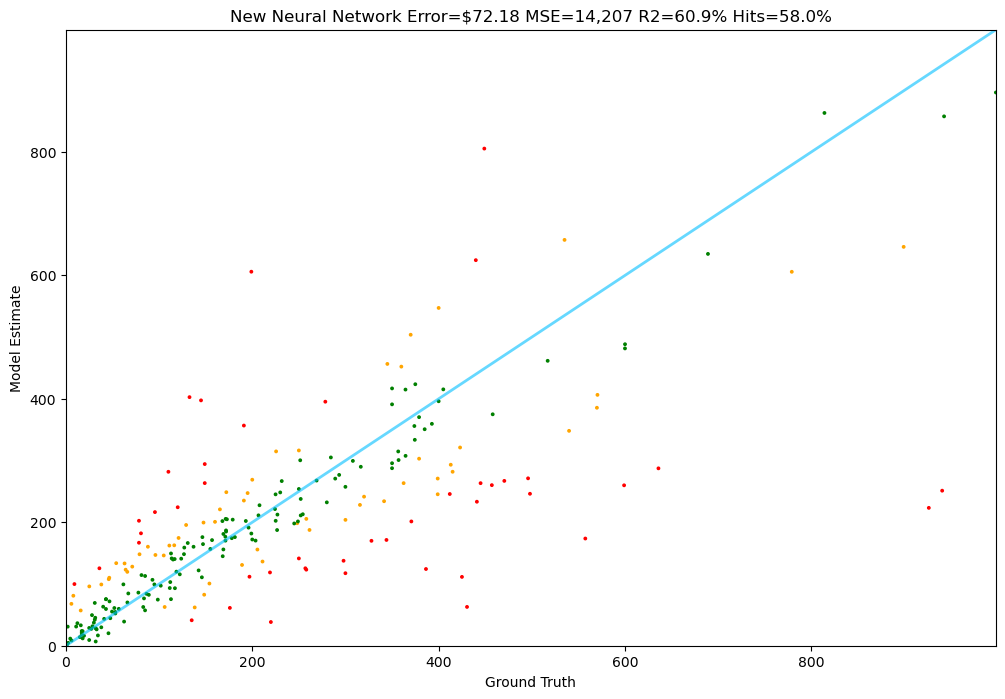

In [39]:
Tester.test(new_neural_network, test)